# Imports and Functions

In [1]:
import pg8000
import pandas as pd    
import os, re
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from allensdk.core.nwb_data_set import NwbDataSet
import allensdk.ephys.ephys_features as aef
import allensdk.ephys.extract_cell_features as ecf
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
import logging
#import umap
#from research_ops_tools.lims2_funcs import get_lims_dataframe
#from allensdk.internal.core.lims_utilities import linux_to_windows

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
np.__version__

'1.16.2'

In [3]:
from sklearn.preprocessing import Imputer

In [135]:
#!pip install -U seaborn
#!pip install -U sklearn

In [4]:
#code from Agata
#these are nice functions to open LIMS, make a query and then close LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        
        #THESE ARE IMPORTANT!!!!!!
        #Every query needs to be closed when done
        cursor.close()             
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

# Culture

In [5]:
#c = raw_input('cell name 1: ')
#d = raw_input('cell name 2: ')

q = """
SELECT cell.patched_cell_container, cell.name,
cell.id,
SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) AS container_date,
ef.*
FROM specimens cell 
JOIN ephys_roi_results err ON cell.ephys_roi_result_id = err.id
JOIN projects proj ON cell.project_id = proj.id
LEFT JOIN ephys_features ef on ef.specimen_id = cell.id
WHERE SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) BETWEEN '190101' AND '200000'
AND proj.code = 'hIVSCC-METc'"""

df1 = get_lims_dataframe(q)
df1
#AND cell.name = '{}'
#AND cell.name = '{}' OR cell.name = '{}'
#.format(c)

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,f_i_curve_slope,created_at,peak_t_long_square,patched_cell_container,latency,fast_trough_v_long_square,upstroke_downstroke_ratio_long_square,trough_v_ramp,peak_v_long_square,adaptation
0,13.388912,1.819779,819205547.0,None,-26.335417,35.643749,1.663914,0.257020,2019-02-06 21:15:28.937910,3.791213,...,0.440000,2019-02-06 21:06:38.209258,0.77122,PXS4_190125_351_A01,0.03586,-56.693748,1.645211,-56.941666,33.431248,0.005169
1,8.359153,1.682270,819205509.0,None,-27.491667,30.456249,1.548367,0.308440,2019-02-06 21:15:41.840076,3.684700,...,0.760000,2019-02-06 21:06:48.794575,0.56042,PXS4_190125_352_A01,0.01128,-55.274998,1.543108,-55.116665,32.431248,0.004595
2,18.784336,2.647530,819205844.0,None,-42.560417,26.225000,2.651446,0.428155,2019-02-06 21:15:59.792092,1.085747,...,0.685714,2019-02-06 21:07:09.997064,0.54622,PXS4_190125_353_A01,0.01154,-65.893745,2.636752,-66.116669,28.225000,0.002489
3,17.850683,4.734689,819206039.0,None,-12.678124,-17.806250,3.971338,0.028632,2019-02-06 21:16:55.499342,4.277853,...,0.100000,2019-02-06 21:08:27.719359,0.60360,PXS4_190125_354_A01,0.05118,-42.625000,2.810915,-29.796875,9.025000,0.262256
4,10.288262,1.943297,819205711.0,None,-17.768749,30.981249,1.101951,0.421515,2019-02-06 21:15:43.198877,6.707287,...,0.485106,2019-02-06 21:06:46.468091,0.96372,PXS4_190125_355_A01,0.02712,-51.875000,1.126817,-51.854168,24.074999,0.008538
5,13.923525,1.777723,819205634.0,None,-21.091667,40.827084,1.461732,0.296505,2019-02-06 21:15:53.914215,5.472540,...,0.354310,2019-02-06 21:06:57.174703,0.96818,PXS4_190125_356_A01,0.01382,-52.487499,1.458961,-53.381252,33.437500,-0.013303
6,14.842336,2.370573,819205931.0,None,-33.329166,32.818748,2.108296,0.437803,2019-02-06 21:15:45.674092,1.937380,...,0.385714,2019-02-06 21:07:02.245281,0.53342,PXS4_190125_357_A01,0.01648,-56.487499,2.388311,-58.637497,35.149998,0.011303
7,13.919652,2.146099,819205874.0,None,-34.279163,39.256248,2.510925,0.220360,2019-02-06 21:16:10.281504,2.721987,...,0.215000,2019-02-06 21:07:20.947972,0.63106,PXS4_190125_358_A01,0.03006,-57.537498,2.082513,-63.020832,33.512501,0.021134
8,26.007560,2.397249,905739286.0,None,-38.585415,28.562500,2.185597,0.369077,2019-07-13 05:09:37.949206,0.940760,...,0.494481,2019-07-13 05:09:37.949206,0.66786,PXS4_190125_359_A01,0.01816,-52.974998,2.177259,-57.060413,30.043749,0.015080
9,19.908757,1.881894,819235798.0,None,-29.189583,36.228748,1.818622,0.482347,2019-02-06 22:11:39.805220,2.082060,...,0.335000,2019-02-06 22:11:39.805220,0.58710,PXS4_190128_351_A01,0.03018,-53.243748,1.996993,-53.204163,37.318748,0.021266


# Acute

In [6]:
#c = raw_input('cell name 1: ')
#d = raw_input('cell name 2: ')

q = """
SELECT cell.patched_cell_container, cell.name,
cell.id,
SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) AS container_date,
ef.*
FROM specimens cell 
JOIN ephys_roi_results err ON cell.ephys_roi_result_id = err.id
JOIN projects proj ON cell.project_id = proj.id
LEFT JOIN ephys_features ef on ef.specimen_id = cell.id
WHERE SUBSTRING(cell.patched_cell_container FROM 6 FOR 6) BETWEEN '171001' AND '200000'
AND proj.code = 'hIVSCC-MET'"""

df = get_lims_dataframe(q)
df
#AND cell.name = '{}'
#AND cell.name = '{}' OR cell.name = '{}'
#.format(c)

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,f_i_curve_slope,created_at,peak_t_long_square,patched_cell_container,latency,fast_trough_v_long_square,upstroke_downstroke_ratio_long_square,trough_v_ramp,peak_v_long_square,adaptation
0,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_401_A01,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_402_A01,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_403_A01,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P8S4_171013_355_A01,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P9S4_171013_404_A01,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_053_A01,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_054_A01,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_055_A01,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P2S4_171016_056_A01,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaT,NaN,P8S4_171017_351_A01,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df1.columns

Index([u'tau', u'upstroke_downstroke_ratio_short_square',
       u'thumbnail_sweep_id', u'has_delay', u'threshold_v_ramp',
       u'peak_v_short_square', u'upstroke_downstroke_ratio_ramp', u'sag',
       u'updated_at', u'threshold_t_ramp', u'slow_trough_v_ramp', u'vrest',
       u'has_pause', u'trough_t_ramp', u'trough_v_long_square',
       u'threshold_t_short_square', u'id', u'trough_t_short_square',
       u'fast_trough_v_ramp', u'trough_t_long_square',
       u'slow_trough_v_long_square', u'rheobase_sweep_id', u'peak_t_ramp',
       u'has_burst', u'slow_trough_t_long_square', u'threshold_v_long_square',
       u'fast_trough_t_long_square', u'ri', u'threshold_t_long_square',
       u'threshold_v_short_square', u'avg_isi', u'vm_for_sag', u'specimen_id',
       u'threshold_i_long_square', u'threshold_i_short_square',
       u'slow_trough_t_ramp', u'peak_v_ramp', u'fast_trough_v_short_square',
       u'fast_trough_t_short_square', u'fast_trough_t_ramp', u'container_date',
       u'slow

In [9]:
#df.to_csv("human_acute_ephys_features.csv")

In [10]:
#df1.to_csv("human_culture_ephys_features.csv")

# Merging dataframes with shiny

In [7]:
shiny = pd.read_csv('human_shiny1.csv')
#shiny = pd.read_csv("Z:\IVSCC_KPIs\shiny_LIMS.csv") column EF
recent_shiny = pd.read_csv('shiny190515.csv')
recent_shiny2 = pd.read_csv('shiny190612.csv')
recent_shiny3 = pd.read_csv('shiny190710.csv')
shiny_frames = [shiny, recent_shiny, recent_shiny2, recent_shiny3]
shiny = pd.concat(shiny_frames)
shiny['class'].value_counts()

Excitatory    601
PVALB         128
VIP           112
LAMP5         109
SST            64
Name: class, dtype: int64

In [8]:
culture_df = pd.merge(left = df1, 
                    right = shiny, 
                    left_on = 'name', #ephys
                    right_on = 'cell_name_label', #shiny
                    how = 'left')
culture_df

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,topLeaf,topLeafValue_color,topLeafValue_id,topLeafValue_label,topLeaf_color,topLeaf_id,topLeaf_label,total_cortical_depth_color,total_cortical_depth_id,total_cortical_depth_label
0,13.388912,1.819779,819205547.0,None,-26.335417,35.643749,1.663914,0.257020,2019-02-06 21:15:28.937910,3.791213,...,NaN,#B7B7DE,29.0,0.36,#4D52FF,46.0,Inh L2-4 PVALB WFDC2,#00008B,1.0,0.0
1,8.359153,1.682270,819205509.0,None,-27.491667,30.456249,1.548367,0.308440,2019-02-06 21:15:41.840076,3.684700,...,NaN,#FF1E1E,87.0,0.94,#4D52FF,46.0,Inh L2-4 PVALB WFDC2,#00008B,1.0,0.0
2,18.784336,2.647530,819205844.0,None,-42.560417,26.225000,2.651446,0.428155,2019-02-06 21:15:59.792092,1.085747,...,NaN,#FF2828,85.0,0.92,#4DFFEF,34.0,Inh L1-3 SST CALB1,#00008B,1.0,0.0
3,17.850683,4.734689,819206039.0,None,-12.678124,-17.806250,3.971338,0.028632,2019-02-06 21:16:55.499342,4.277853,...,NaN,#FFD1D1,52.0,0.59,#17993D,27.0,Inh L1-2 PAX6 CDH12,#00008B,1.0,0.0
4,10.288262,1.943297,819205711.0,None,-17.768749,30.981249,1.101951,0.421515,2019-02-06 21:15:43.198877,6.707287,...,NaN,#FF4C4C,78.0,0.85,#291FCC,47.0,Inh L2-4 SST FRZB,#00008B,1.0,0.0
5,13.923525,1.777723,819205634.0,None,-21.091667,40.827084,1.461732,0.296505,2019-02-06 21:15:53.914215,5.472540,...,NaN,#FF2323,86.0,0.93,#4D52FF,46.0,Inh L2-4 PVALB WFDC2,#00008B,1.0,0.0
6,14.842336,2.370573,819205931.0,None,-33.329166,32.818748,2.108296,0.437803,2019-02-06 21:15:45.674092,1.937380,...,NaN,#5B5BB4,11.0,0.18,#9473FF,49.0,Inh L2-5 PVALB SCUBE3,#00008B,1.0,0.0
7,13.919652,2.146099,819205874.0,None,-34.279163,39.256248,2.510925,0.220360,2019-02-06 21:16:10.281504,2.721987,...,NaN,#FF0000,93.0,1.00,#8000FF,52.0,Inh L2-6 LAMP5 CA1,#00008B,1.0,0.0
8,26.007560,2.397249,905739286.0,None,-38.585415,28.562500,2.185597,0.369077,2019-07-13 05:09:37.949206,0.940760,...,NaN,#FF8989,66.0,0.73,#762E99,54.0,Inh L3-5 SST ADGRG6,#00008B,1.0,0.0
9,19.908757,1.881894,819235798.0,None,-29.189583,36.228748,1.818622,0.482347,2019-02-06 22:11:39.805220,2.082060,...,NaN,#FF7A7A,69.0,0.76,#4DFFEF,34.0,Inh L1-3 SST CALB1,#00008B,1.0,0.0


In [8]:
culture_df2 = pd.merge(left = culture_df, 
                    right = culture_metadata_short, 
                    left_on = 'name', 
                    right_on = 'File', 
                    how = 'left')

NameError: name 'culture_metadata_short' is not defined

In [10]:
acute_df = pd.merge(left = df, 
                    right = shiny, 
                    left_on = 'name', #ephys
                    right_on = 'cell_name_label', #shiny
                    how = 'left')
acute_df['specimen_id']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11              NaN
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19              NaN
20              NaN
21              NaN
22              NaN
23              NaN
24              NaN
25              NaN
26              NaN
27              NaN
28              NaN
29              NaN
           ...     
1277    911059044.0
1278    911063433.0
1279    911076688.0
1280    911080659.0
1281    911084481.0
1282            NaN
1283    911108773.0
1284    911111047.0
1285    911123518.0
1286    911130426.0
1287    911137377.0
1288    911150062.0
1289    911155494.0
1290    911161601.0
1291    923084897.0
1292    923098709.0
1293    923103580.0
1294    923104864.0
1295    923108619.0


In [14]:
#culture_df.to_csv("human_culture_ephys_features_shiny.csv")

In [12]:
acute_df.to_csv("human_acute_ephys_features_shiny.csv")

# Lindsay only dataframe

In [16]:
lindsay_acute= acute_df[acute_df['patched_cell_container'].str.contains('_35|_36|_37')]
lindsay_acute.tail()

,tau,upstroke_downstroke_ratio_short_square,thumbnail_sweep_id,has_delay,threshold_v_ramp,peak_v_short_square,upstroke_downstroke_ratio_ramp,sag,updated_at,threshold_t_ramp,...,contaminationType_color,seurat_cluster_label,caret_cluster_label,caret_correlation_label,seurat_cluster_id,seurat_cluster_color,caret_cluster_id,caret_cluster_color,caret_correlation_id,caret_correlation_color
1192,22.585982,1.935354,880359180.0,None,-39.140621,5.817708,2.475374,0.389121,2019-06-04 02:40:50.184392,1.234913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1210,22.557407,2.670205,880966455.0,None,-36.074997,39.775002,2.684168,0.083085,2019-06-05 04:14:36.591002,2.109800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1212,15.742365,2.221146,880966298.0,None,-19.068750,52.899998,2.155902,0.153081,2019-06-05 04:14:35.643381,2.100167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1215,30.174841,3.430548,880966446.0,None,-35.327084,47.606247,3.563609,0.073891,2019-06-05 04:14:35.127005,1.687733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
lindsay_culture = culture_df[culture_df['patched_cell_container'].str.contains('_35|_36|_37')]
lindsay_culture['class'].head()

0    PVALB
1    PVALB
2      SST
3      NaN
4      SST
Name: class, dtype: object

# Plotting

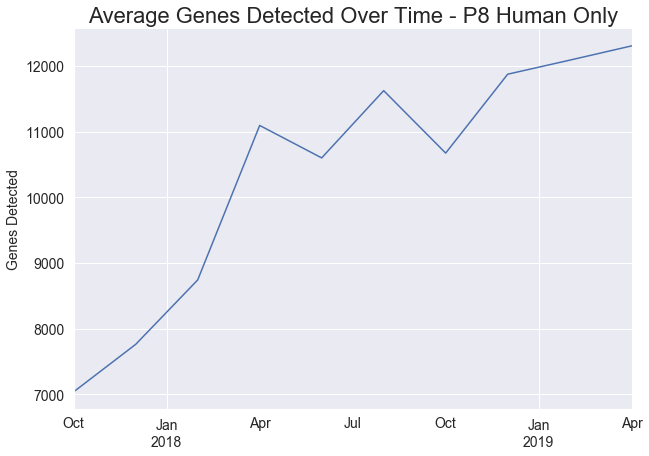

In [18]:
lindsay_acute = lindsay_acute[lindsay_acute['postPatch_label'] == 'nucleus_present']
lindsay_acute["container_date"] = pd.to_datetime(lindsay_acute["container_date"], format = '%y%m%d', errors = 'coerce')
lindsay_acute.sort_values("container_date", axis = 0, inplace = True)
lindsay_acute.set_index("container_date", inplace=True)
ps3 = lindsay_acute.groupby(pd.TimeGrouper(freq="2m"))["genes_label"].mean()
ps3.plot(figsize=(10,7), fontsize= 14)
plt.title("Average Genes Detected Over Time - P8 Human Only", fontsize= 22, loc = "center")
plt.ylabel("Genes Detected", fontsize= 14)
plt.xlabel("")
sns.despine()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/genes_detected_over_time")

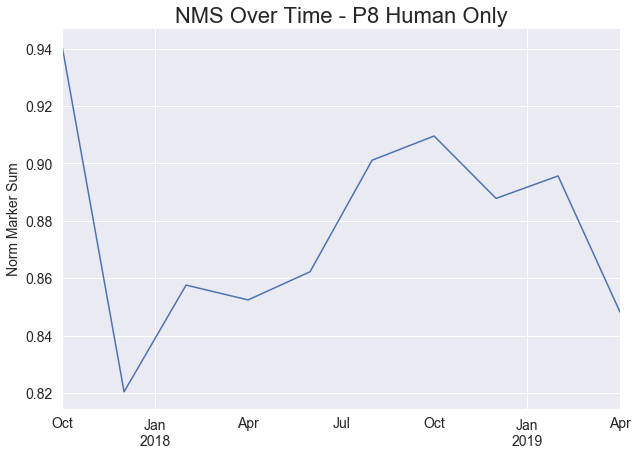

In [19]:
ps4 = lindsay_acute.groupby(pd.TimeGrouper(freq="2m"))["marker_sum_norm_label"].mean()
ps4.plot(figsize=(10,7), fontsize= 14)
plt.title("NMS Over Time - P8 Human Only", fontsize= 22, loc = "center")
plt.ylabel("Norm Marker Sum", fontsize= 14)
plt.xlabel("")
sns.despine()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/NMS_over_time")

In [20]:
lindsay_culture = lindsay_culture[lindsay_culture['class'].notnull()] 



In [18]:
color_palette=dict(PVALB="mediumpurple", SST="coral", LAMP5='turquoise', Excitatory= 'gold', VIP= 'royalblue')
color_palette2=["mediumpurple","coral",'turquoise','gold','royalblue']

In [19]:
classes = ['PVALB','SST','LAMP5','Excitatory','VIP']

In [23]:
acute_df['fast_ahp']= acute_df['threshold_v_short_square'] - acute_df['fast_trough_v_short_square']
acute_df['fast_ahp']

culture_df['fast_ahp']= culture_df['threshold_v_short_square'] - culture_df['fast_trough_v_short_square']
acute_df[acute_df['class']=='SST']['name']

6         H17.06.013.12.05.02
29        H17.26.003.11.14.01
64        H17.06.015.11.06.06
223       H18.03.005.11.06.05
277       H18.03.008.11.15.07
290       H18.03.009.11.16.02
384    H18.03.012.11.07.02.02
446    H18.26.404.11.05.01.01
499    H18.03.313.11.15.01.04
620    H18.03.316.11.14.01.01
668    H18.03.317.12.09.01.04
682    H18.06.366.15.21.01.03
865    H18.06.371.12.04.01.01
992    H19.03.305.11.10.01.10
Name: name, dtype: object

In [10]:
sst = pd.read_csv('extra_sst.csv')
new = [sst,acute_df]
extra_sst_df = pd.concat(new)


In [11]:
culture_df[culture_df['class'] == 'SST']['name'].count()

33

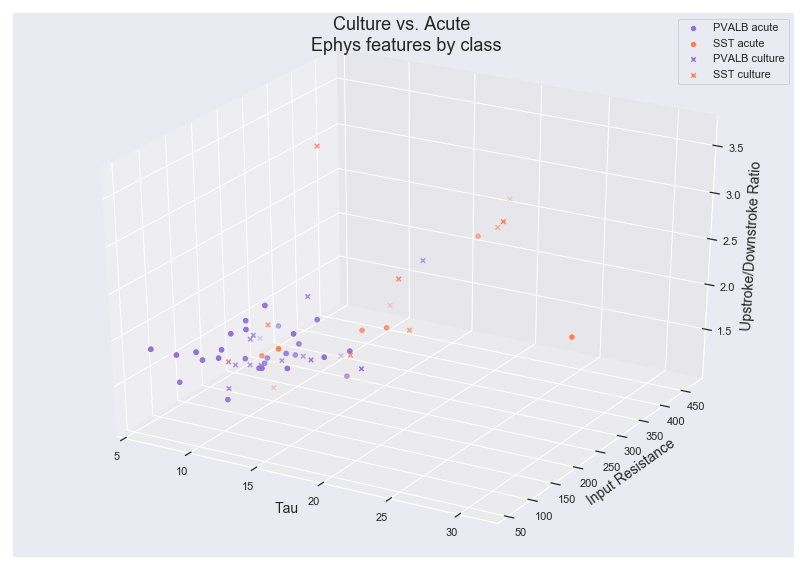

In [26]:
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(14,10))
ax = plt.axes(projection='3d')
for i in range(2):
    df = extra_sst_df[extra_sst_df['class'] == classes[i]]
    x=df['tau']
    y=df['ri']
    z=df['upstroke_downstroke_ratio_long_square']
    ax.scatter3D(x,y,z,color=color_palette2[i], label = classes[i] + ' acute',marker='o')
for i in range(2):
    df = culture_df[culture_df['class'] == classes[i]]
    x=df['tau']
    y=df['ri']
    z=df['upstroke_downstroke_ratio_long_square']
    ax.scatter3D(x,y,z,color=color_palette2[i], label = classes[i] + ' culture',marker='x')
plt.title('Culture vs. Acute \n Ephys features by class', fontsize=18)
#plt.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('Tau', fontsize=14)
ax.set_ylabel('Input Resistance', fontsize=14)
ax.set_zlabel('Upstroke/Downstroke Ratio', fontsize=14)
ax.legend()
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/acute_vs_culture_3D", dpi=300)

In [154]:
lindsay_culture['project']= 'culture'
lindsay_acute['project']= 'acute'

culture_df['project']= 'culture'
acute_df['project']= 'acute'


In [142]:
lindsay_acute['project'].tail()

container_date
2019-03-05    acute
2019-03-05    acute
2019-03-05    acute
2019-03-05    acute
2019-03-05    acute
Name: project, dtype: object

In [11]:
extra_sst_df2= extra_sst_df[extra_sst_df['class'] =='SST']
extra_sst_df2['project'] = 'acute'
extra_sst_df2['specimen_id']

NameError: name 'extra_sst_df' is not defined

In [112]:
#combine acute and culture frames into one dataframe
#frames = [lindsay_acute, lindsay_culture]
frames2 = [acute_df, culture_df2, extra_sst_df2]

#lindsay_all = pd.concat(frames)
all_df = pd.concat(frames2)

In [16]:
culture_df['specimen_id']

0      819074590.0
1      819106998.0
2      819116654.0
3      819133824.0
4      819166048.0
5      819177874.0
6      819181018.0
7      819185246.0
8      819191383.0
9      819194697.0
10     819197541.0
11     819200626.0
12     819206421.0
13     819209252.0
14     819211417.0
15     819213795.0
16     819216709.0
17     819219148.0
18     819221461.0
19     819223815.0
20     819226453.0
21     819229114.0
22     819770858.0
23     819891764.0
24     819923514.0
25     819983199.0
26     820022943.0
27     820061176.0
28     820129320.0
29     837579858.0
          ...     
211    886973131.0
212    887030548.0
213    887128117.0
214    893412652.0
215    893436296.0
216    893455915.0
217    893462603.0
218    893503755.0
219    893540979.0
220    893581479.0
221    893586875.0
222            NaN
223    893606027.0
224    893647190.0
225    893655882.0
226    893680083.0
227    893695351.0
228    893714311.0
229    893734690.0
230    893758012.0
231    894198050.0
232    89425

In [22]:
fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(x="upstroke_downstroke_ratio_long_square", y="ri", data=all_df, hue='class', legend='full', style='cell_specimen_project_label', palette= color_palette,s=50)
plt.title("Acute vs Culture \n Ephys features by class", fontsize= 17, loc = "center")
plt.ylabel("Input Resistance", fontsize= 14)
plt.xlabel("Upstroke/Downstroke Ratio", fontsize= 14)
#plt.gcf().subplots_adjust(top=0.92)
#plt.ylim(50, 600)
#plt.xlim(1, 6)
#plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/acute_vs_culture_ephys_features")

In [48]:
all_df

NameError: name 'all_df' is not defined

In [28]:
features1 = ['tau', 'upstroke_downstroke_ratio_short_square',
       'has_delay', 'threshold_v_ramp',
       'peak_v_short_square', 'upstroke_downstroke_ratio_ramp', 'sag',
       'threshold_t_ramp', 'slow_trough_v_ramp', 'vrest',
       'has_pause', 'trough_t_ramp', 'trough_v_long_square',
       'threshold_t_short_square', 'trough_t_short_square',
       'fast_trough_v_ramp', 'trough_t_long_square',
       'slow_trough_v_long_square', 'peak_t_ramp',
       'has_burst', 'slow_trough_t_long_square', 'threshold_v_long_square',
       'fast_trough_t_long_square', 'ri', 'threshold_t_long_square',
       'threshold_v_short_square', 'avg_isi', 'vm_for_sag',
       'threshold_i_long_square', 'threshold_i_short_square',
       'slow_trough_t_ramp', 'peak_v_ramp', 'fast_trough_v_short_square',
       'fast_trough_t_short_square', 'fast_trough_t_ramp',
       'slow_trough_t_short_square', 'threshold_i_ramp',
       'slow_trough_v_short_square', 'peak_t_short_square',
       'trough_v_short_square', 'f_i_curve_slope',
       'peak_t_long_square', 'latency',
       'fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square',
       'trough_v_ramp', 'peak_v_long_square', 'adaptation']

features =['ri','upstroke_downstroke_ratio_long_square', 'tau']

In [29]:
all_df4 = all_df.dropna(subset= features+['class'])

In [102]:
all_df2 = all_df[all_df['class'].notnull()]
all_df3 = all_df2[all_df2['ri'].notnull()]
all_df4['name']

0            H18.06.004.11.04.02
1            H18.03.010.11.15.01
2            H18.03.010.11.10.02
3            H18.03.010.11.14.02
4            H18.03.010.11.15.02
5            H18.03.010.11.10.03
6            H18.03.010.11.10.04
7            H18.03.010.11.14.04
8            H18.03.010.11.10.05
9            H18.03.010.11.15.04
10           H18.03.010.11.10.06
11           H18.03.010.11.14.05
12           H18.03.010.11.10.07
13           H18.03.010.11.15.05
14           H18.03.010.11.14.06
15           H18.03.010.11.10.08
16           H18.03.010.11.15.06
17           H18.03.010.11.14.07
18           H18.03.010.11.15.07
19           H18.03.010.11.10.10
20           H18.03.010.11.14.08
21           H18.03.010.11.14.09
22           H18.03.010.11.10.11
23           H18.03.010.11.14.10
24           H18.03.010.11.10.13
25           H18.03.010.11.15.09
26           H18.03.010.11.15.10
27           H18.03.010.11.10.14
28           H18.03.010.11.11.02
29           H18.03.010.11.11.03
          

In [9]:
culture_metadata = pd.read_csv('culture_metadata.csv')
culture_metadata_short = culture_metadata.loc[:,['File','DIV']]
culture_metadata_short.dropna()

all_df4 = pd.merge(left = all_df4, 
                    right = culture_metadata_short, 
                    left_on = 'name', 
                    right_on = 'File', 
                    how = 'left')
all_df4['DIV']


NameError: name 'all_df4' is not defined

In [35]:
x = all_df4.loc[:,features].values
y = all_df4.loc[:,['class']].values
x = StandardScaler().fit_transform(x)

In [36]:
pd.DataFrame(data = x, columns = features)

,ri,upstroke_downstroke_ratio_long_square,tau
0,-1.031331,0.561592,-0.772954
1,-0.872288,-0.257320,0.323253
2,-0.639959,0.178131,0.994135
3,-0.058358,0.088773,0.364179
4,-1.354096,2.018825,0.030421
5,-1.126446,0.529089,0.345700
6,-0.844221,0.578258,0.044065
7,-0.356175,-0.094541,0.276296
8,0.663575,1.149410,1.069355
9,-0.897236,-0.023663,0.279448


In [37]:
#imp = Imputer(strategy='mean',axis =0)
#scale= StandardScaler()
#x = scale.fit_transform(imp.fit_transform(x))

In [38]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2'])
#finalDf = pd.concat([principalDf, all_df[['class']]], axis=1)
principalDf

,principal component 1,principal component 2
0,-0.512187,-1.246301
1,-0.165686,-0.579845
2,0.661521,-0.535427
3,0.306270,-0.057891
4,0.886356,-2.184236
5,0.264125,-1.196348
6,0.151747,-1.011494
7,0.045007,-0.227372
8,1.681488,0.088381
9,-0.060918,-0.725031


In [98]:
all_df4['DIV']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
      ... 
442    6.0
443    6.0
444    4.0
445    4.0
446    4.0
447    4.0
448    4.0
449    4.0
450    4.0
451    4.0
452    4.0
453    4.0
454    4.0
455    NaN
456    7.0
457    7.0
458    NaN
459    NaN
460    NaN
461    NaN
462    NaN
463    NaN
464    NaN
465    NaN
466    NaN
467    NaN
468    NaN
469    NaN
470    NaN
471    NaN
Name: DIV, Length: 472, dtype: float64

In [40]:
#finalDf = principalDf.join(all_df3[['class']])

all_df4.reset_index(drop=True, inplace=True)
principalDf.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, all_df4[['class']]], axis=1)
finalDf

,principal component 1,principal component 2,class
0,-0.512187,-1.246301,Excitatory
1,-0.165686,-0.579845,Excitatory
2,0.661521,-0.535427,Excitatory
3,0.306270,-0.057891,Excitatory
4,0.886356,-2.184236,Excitatory
5,0.264125,-1.196348,Excitatory
6,0.151747,-1.011494,Excitatory
7,0.045007,-0.227372,Excitatory
8,1.681488,0.088381,Excitatory
9,-0.060918,-0.725031,Excitatory


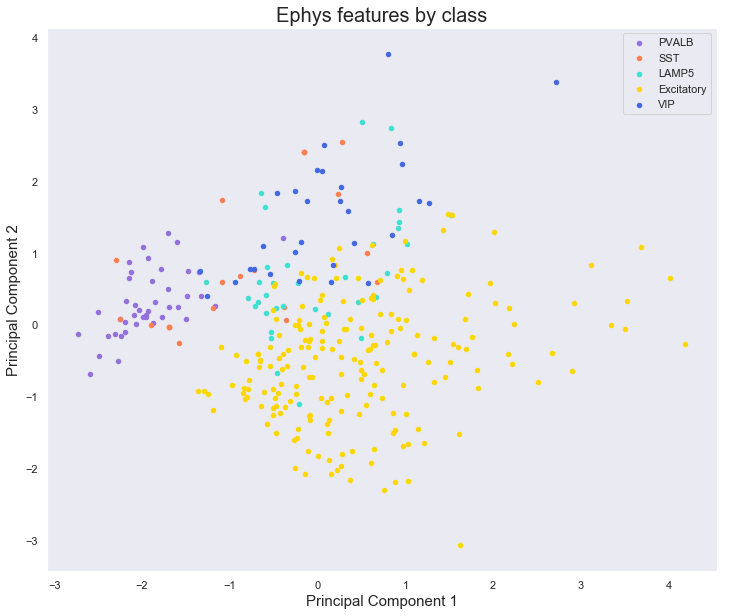

In [41]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Ephys features by class', fontsize = 20)

targets = ['PVALB','SST','LAMP5','Excitatory','VIP']
colors = ["mediumpurple","coral",'turquoise','gold','royalblue']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()

In [42]:
ipfx_features = pd.read_csv('culture_features.csv')
ipfx_features
new = all_df4[all_df4['specimen_id'].notnull()]
all_cells= pd.DataFrame(new['specimen_id'])
all_cells.to_csv("all_cells.csv")

In [43]:
merged_df = pd.merge(left = all_df, 
                    right = ipfx_features, 
                    left_on = 'specimen_id', 
                    right_on = 'specimen_id', 
                    how = 'left')

In [44]:
merged_df['ap_1_width_0_long_square']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
1356   NaN
1357   NaN
1358   NaN
1359   NaN
1360   NaN
1361   NaN
1362   NaN
1363   NaN
1364   NaN
1365   NaN
1366   NaN
1367   NaN
1368   NaN
1369   NaN
1370   NaN
1371   NaN
1372   NaN
1373   NaN
1374   NaN
1375   NaN
1376   NaN
1377   NaN
1378   NaN
1379   NaN
1380   NaN
1381   NaN
1382   NaN
1383   NaN
1384   NaN
1385   NaN
Name: ap_1_width_0_long_square, Length: 1386, dtype: float64

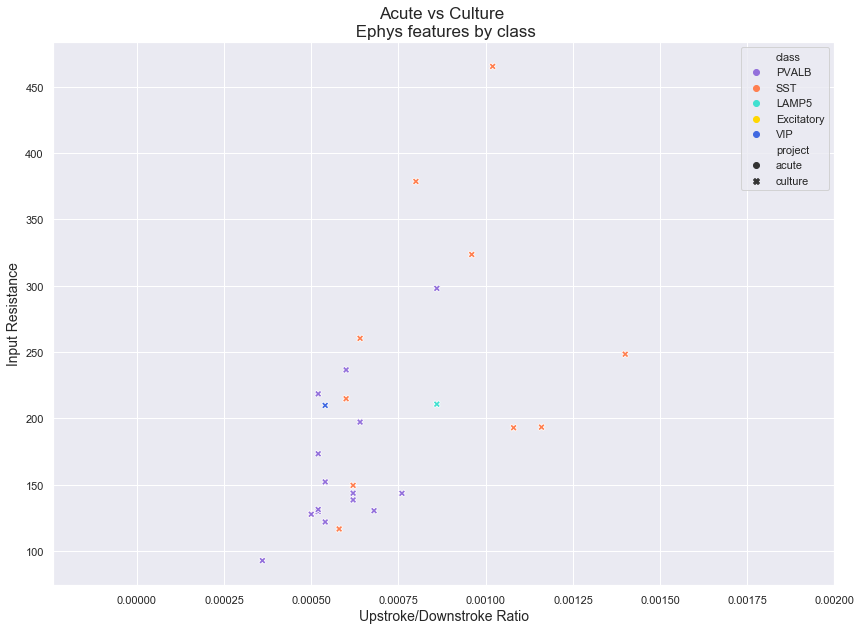

In [45]:
fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(x="ap_1_width_0_long_square", y="ri", data=merged_df, hue='class', legend='full', style='project', palette= color_palette,s=50)
plt.title("Acute vs Culture \n Ephys features by class", fontsize= 17, loc = "center")
plt.ylabel("Input Resistance", fontsize= 14)
plt.xlabel("Upstroke/Downstroke Ratio", fontsize= 14)
#plt.gcf().subplots_adjust(top=0.92)
#plt.ylim(50, 600)
#plt.xlim(1, 6)
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/acute_vs_culture_ephys_features")

In [25]:
orig_file = "\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\spca_output\\sparse_pca_components_human_inh_me_met.csv"
spca_df = pd.read_csv(orig_file, index_col=0)
spca_df

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
488386504,-0.589404,-1.420078,-0.696331,-0.636510,-0.009487,-1.349655,0.330378,0.380669,-0.081579,1.585245,...,-1.314876,0.535222,-1.594831,-0.587235,-0.817098,0.820578,0.100433,-1.292171,-0.248031,-1.627385
488386626,-0.434633,-1.243488,-1.517460,-0.138346,0.089382,-1.423242,-1.404030,-0.136525,-0.849850,0.126114,...,-1.306218,0.565754,-1.622310,-0.424861,-1.406682,-0.217615,0.821575,1.417539,0.543880,0.690381
488400343,-0.394471,-0.726248,0.068836,-0.866358,-0.023302,-0.312598,-0.432061,-0.508505,-1.094807,-1.055331,...,-0.487083,-0.231143,-0.869683,0.928861,-0.536391,-1.928981,-0.792165,0.846122,-2.930193,0.248344
488418027,-0.475845,-1.019352,0.064222,-0.096045,0.050059,-0.929475,-0.041587,-0.225503,-1.886105,-0.423859,...,-0.928247,0.137184,-1.363780,-0.392785,-0.491615,0.711858,-1.248337,0.924385,0.854300,-0.619302
508281653,-0.607842,-1.346662,-0.349883,-0.272765,0.037366,-1.622753,-0.346276,0.045495,-1.450740,1.256577,...,-1.131040,0.695852,-1.304404,0.320448,-1.641611,-0.649973,0.988883,0.554436,-0.897670,0.948719
508381644,-0.487756,-0.762927,0.626424,-0.381491,-0.050333,-0.495437,0.237661,-1.682302,-0.762200,0.804510,...,-0.733114,-0.044100,-1.245865,-0.443245,0.054543,1.162033,-1.822770,0.533993,0.690580,-0.724110
508400236,-0.493279,-1.016791,0.139558,-0.369844,-0.011565,-0.811032,0.164276,-1.918103,-0.877647,-0.109018,...,-0.928247,0.137184,-1.536566,-0.374617,-1.403870,-0.301857,0.772509,1.098612,0.690649,0.592462
519853636,0.666816,1.238174,-3.347922,-1.327675,-0.114303,1.098586,-2.886635,1.416339,-0.309595,0.429000,...,0.921934,-0.690363,-1.206803,-0.912676,0.286152,1.649857,-1.069955,0.326472,-0.598128,-0.012073
520631985,-0.298108,-0.200289,1.086284,-0.719679,-0.057495,0.283573,0.300458,-2.090431,-1.540521,0.882212,...,-0.308239,-1.091156,0.706652,1.483010,1.493565,0.828340,0.673638,0.129636,0.500959,0.521398
525018757,-0.425585,-0.958019,0.178196,0.587048,-0.029946,-1.097561,1.531890,0.426491,-0.123878,-1.767628,...,-0.909801,0.424115,0.425601,-0.791786,-1.146609,-2.074773,1.585761,0.819565,0.199808,-3.639364


In [47]:
import sklearn.manifold as manifold

In [48]:
tsne = manifold.TSNE(random_state=2)

In [49]:
y = tsne.fit_transform(spca_df)


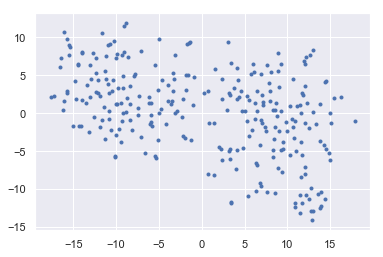

In [50]:
plt.plot(y[:, 0], y[:, 1], '.')

In [23]:
#culture_spca_df = pd.read_csv("culture_spca.csv", index_col=0)
#culture_spca_df = pd.read_csv("culture190612_spca.csv", index_col=0)
culture_spca_df = pd.read_csv("culture190710_spca.csv", index_col=0)

In [24]:
culture_spca_df

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
819074590,-0.290548,-0.546424,0.358882,0.933401,-0.006933,-0.497999,0.690409,-1.826351,-0.149294,1.161087,...,-0.722582,-0.238123,2.117034,-1.247308,-0.522299,0.627952,-0.739604,0.321645,1.214828,-0.622272
819106998,-0.215996,-0.349307,0.345296,0.783839,-0.093888,-0.126022,0.906962,-0.673853,-0.981481,-0.433904,...,-0.745127,-0.257391,0.948498,-0.042313,0.880220,0.084949,2.201630,1.098782,-0.118814,-2.402126
819116654,0.140858,0.971359,0.235943,-1.419193,-0.117023,0.810559,-0.681390,-1.416082,0.806904,0.293739,...,1.215750,-0.918386,1.261204,-0.224289,-0.775982,0.217354,-0.688999,0.148786,-0.319979,0.832988
819133824,0.865171,0.884170,-3.009645,2.757307,0.347811,0.536171,-1.588848,0.840742,1.600153,0.560492,...,1.265862,-2.748251,-0.054493,-0.184474,1.477927,0.987605,0.766184,-0.309616,1.149919,0.123161
819166048,0.302268,0.990643,-1.141691,-0.430624,-0.095607,0.732982,-1.853735,-1.969159,-0.990811,0.119485,...,1.012172,-2.343528,0.868858,1.062804,-0.556500,-0.451510,-1.294689,-0.516730,5.131725,-0.177631
819177874,-0.116420,-0.142865,0.458135,1.290868,-0.024551,0.068275,0.654309,-1.128486,-1.203251,2.617778,...,-0.488505,-0.433652,-0.316934,0.722884,-2.725794,0.916198,1.662496,-1.489659,0.125489,-0.835390
819181018,0.506428,0.598093,-1.243081,0.704199,0.082644,0.657886,-0.934104,-1.350303,1.197344,0.918566,...,0.460059,-0.177621,-0.278646,0.810488,0.313618,0.687725,-0.080796,0.459055,-1.019605,-0.051021
819185246,0.063213,0.694620,1.128184,-0.378262,-0.109107,0.880611,0.339848,-1.584930,-0.256964,-1.932682,...,0.308787,-1.672747,0.169428,-0.685502,0.150972,0.983206,0.628530,0.497719,-0.469113,0.160087
819191383,0.656131,1.268662,-3.269181,1.037968,0.299985,0.876610,-2.357769,-0.588864,1.241119,0.254003,...,1.478403,-2.098656,-0.385728,-0.753656,2.184277,0.363639,-0.722057,-0.542152,0.361766,2.568356
819194697,-0.004116,0.276920,0.617703,0.874261,-0.154700,0.578405,0.762898,-1.206374,1.585629,0.285602,...,-0.157136,0.180985,0.423101,0.638497,1.001935,0.433753,0.241513,0.450177,0.250637,-0.514921


In [113]:
classes = all_df[['class','cluster_label','specimen_id', 'DIV']]
#classes.to_csv('class_by_id.csv')

In [32]:
combo_df = pd.concat([spca_df, culture_spca_df])

In [33]:
combo_df.to_csv('combo_df.csv')
spca_df.to_csv('spca_df.csv')
culture_spca_df.to_csv('culture_spca190710_df.csv')

In [34]:
combo_df.shape

(508, 47)

In [129]:
classes.drop_duplicates(inplace=True)

In [130]:
classes

,class,cluster_label,specimen_id,DIV
0,NaN,FAIL,NaN,NaN
2,PVALB,Inh L2-4 PVALB WFDC2,NaN,NaN
5,NaN,Inhibitory,NaN,NaN
6,SST,SST|g,NaN,NaN
9,LAMP5,Inh L1-4 LAMP5 LCP2 (rosehip),NaN,NaN
15,PVALB,Inh L4-5 PVALB MEPE,NaN,NaN
16,NaN,LHX6|a,NaN,NaN
25,Excitatory,Excitatory,NaN,NaN
28,NaN,LHX6|b,NaN,NaN
29,SST,Inh L5-6 SST MIR548F2,NaN,NaN


In [131]:
#combo_df.reset_index(inplace=True)
class_call_df = pd.merge(left = combo_df, 
                    right = classes, 
                    left_on = 'index', 
                    right_on = 'specimen_id', 
                    how = 'left')

In [125]:
#class_call_df.drop(['level_0'], axis = 1, inplace =True)
class_call_df['DIV'].values

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [133]:
class_call_df.to_csv('class_call_df.csv')
#class_by_id = class_call_df[['index','class']].dropna()
#class_by_id.to_csv('class_by_id.csv')

In [132]:
class_call_df

,level_0,index,0,1,2,3,4,5,6,7,...,41,42,43,44,45,46,class,cluster_label,specimen_id,DIV
0,0,488386504,-0.589404,-1.420078,-0.696331,-0.636510,-0.009487,-1.349655,0.330378,0.380669,...,-0.817098,0.820578,0.100433,-1.292171,-0.248031,-1.627385,NaN,NaN,NaN,NaN
1,1,488386626,-0.434633,-1.243488,-1.517460,-0.138346,0.089382,-1.423242,-1.404030,-0.136525,...,-1.406682,-0.217615,0.821575,1.417539,0.543880,0.690381,NaN,NaN,NaN,NaN
2,2,488400343,-0.394471,-0.726248,0.068836,-0.866358,-0.023302,-0.312598,-0.432061,-0.508505,...,-0.536391,-1.928981,-0.792165,0.846122,-2.930193,0.248344,NaN,NaN,NaN,NaN
3,3,488418027,-0.475845,-1.019352,0.064222,-0.096045,0.050059,-0.929475,-0.041587,-0.225503,...,-0.491615,0.711858,-1.248337,0.924385,0.854300,-0.619302,NaN,NaN,NaN,NaN
4,4,508281653,-0.607842,-1.346662,-0.349883,-0.272765,0.037366,-1.622753,-0.346276,0.045495,...,-1.641611,-0.649973,0.988883,0.554436,-0.897670,0.948719,NaN,NaN,NaN,NaN
5,5,508381644,-0.487756,-0.762927,0.626424,-0.381491,-0.050333,-0.495437,0.237661,-1.682302,...,0.054543,1.162033,-1.822770,0.533993,0.690580,-0.724110,NaN,NaN,NaN,NaN
6,6,508400236,-0.493279,-1.016791,0.139558,-0.369844,-0.011565,-0.811032,0.164276,-1.918103,...,-1.403870,-0.301857,0.772509,1.098612,0.690649,0.592462,NaN,NaN,NaN,NaN
7,7,519853636,0.666816,1.238174,-3.347922,-1.327675,-0.114303,1.098586,-2.886635,1.416339,...,0.286152,1.649857,-1.069955,0.326472,-0.598128,-0.012073,NaN,NaN,NaN,NaN
8,8,520631985,-0.298108,-0.200289,1.086284,-0.719679,-0.057495,0.283573,0.300458,-2.090431,...,1.493565,0.828340,0.673638,0.129636,0.500959,0.521398,NaN,NaN,NaN,NaN
9,9,525018757,-0.425585,-0.958019,0.178196,0.587048,-0.029946,-1.097561,1.531890,0.426491,...,-1.146609,-2.074773,1.585761,0.819565,0.199808,-3.639364,NaN,NaN,NaN,NaN


In [75]:
y = tsne.fit_transform(combo_df)

In [62]:
spca_df.shape[0]

275

In [63]:
culture_mask = np.array([False] * spca_df.shape[0] + [True] * culture_spca_df.shape[0])

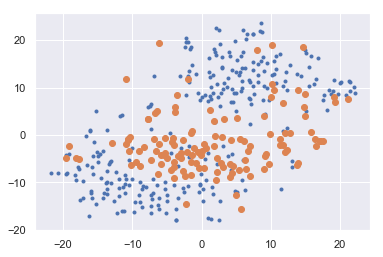

In [76]:
plt.plot(y[:, 0], y[:, 1], '.')
plt.plot(y[culture_mask, 0], y[culture_mask, 1], 'o')

In [123]:
class_call_df.shape

(510, 52)

In [89]:
combo_df.shape

(508, 49)

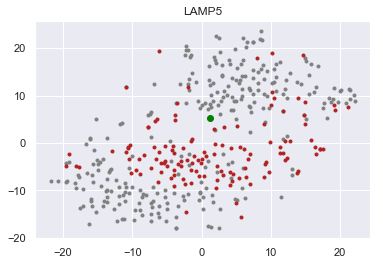

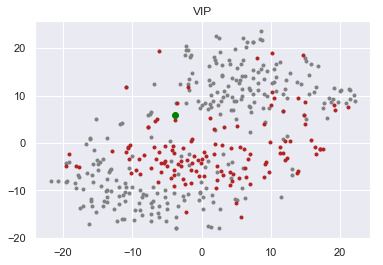

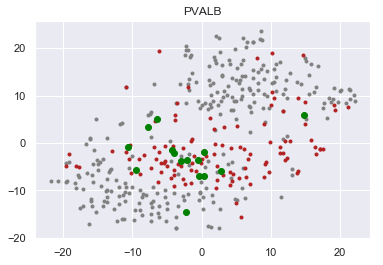

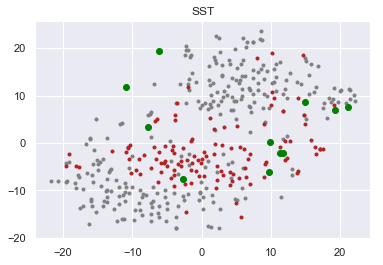

In [77]:

for cc in class_call_df["class"].unique():
    if type(cc) is not str:
        continue
    plt.figure()
    mask = (class_call_df["class"] == cc) & culture_mask
    plt.plot(y[~culture_mask, 0], y[~culture_mask, 1], '.', c="gray")
    plt.plot(y[culture_mask, 0], y[culture_mask, 1], '.', c='firebrick')
    plt.plot(y[mask, 0], y[mask, 1], 'o', c="green")
    plt.title(cc)

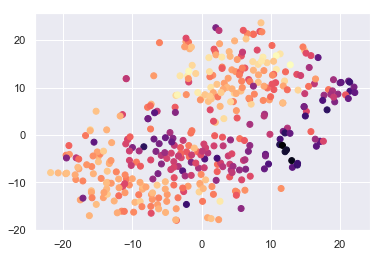

In [78]:
plt.scatter(y[:, 0], y[:, 1], c=combo_df.iloc[:,13].values, cmap="magma")

##### 9,12,15,37

In [69]:
#combo_df

In [2]:
import drcme.load_data as ld
import json

In [3]:
with open("C:/Users/lindsayn/documents/github/drcme/drcme/bin/culture_spca_transform_config.json", "r") as f:
    config = json.load(f)

In [4]:
config

{u'new_datasets': [{u'allow_missing_dendrite': True,
   u'allow_missing_structure': True,
   u'data_dir': u'culture_vectors',
   u'dendrite_type': u'all',
   u'project': u'T301'}],
 u'orig_datasets': [{u'allow_missing_dendrite': False,
   u'allow_missing_structure': False,
   u'data_dir': u'\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\fv_output',
   u'dendrite_type': u'aspiny',
   u'project': u'H301'},
  {u'allow_missing_dendrite': True,
   u'allow_missing_structure': True,
   u'data_dir': u'\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\fv_output',
   u'dendrite_type': u'all',
   u'project': u'curated_hMET_inh'}],
 u'orig_transform_file': u'\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\spca_output\\spca_loadings_human_inh_me_met.pkl',
 u'output_file': u'culture_spca.csv',
 u'params_file': u'\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\shared_spca_config\\met_spca_params.json'}

In [13]:
orig_datasets = config["orig_datasets"]
params_file = config["params_file"]
use_noise = False

spca_zht_params, _ = ld.define_spca_parameters(params_file)

# spca_results = joblib.load(orig_transform_file)

# These arguments should be parameterized
orig_data_objects = []
orig_specimen_ids_list = []
for ds in orig_datasets:
    limit_to_cortical_layers = None

    data_for_spca, specimen_ids = ld.load_organized_data(project=ds["project"],
                                        base_dir=ds["data_dir"],
                                        use_noise=use_noise,
                                        dendrite_type=ds["dendrite_type"],
                                        need_structure=not ds["allow_missing_structure"],
                                        include_dend_type_null=ds["allow_missing_dendrite"],
                                        limit_to_cortical_layers=limit_to_cortical_layers,
                                        params_file=params_file)
    orig_data_objects.append(data_for_spca)
    orig_specimen_ids_list.append(specimen_ids)
orig_data_for_spca = []
for i, do in enumerate(orig_data_objects):
    for j, data_item in enumerate(do):
        if i == 0:
            orig_data_for_spca.append({
                "data": data_item["data"].copy(),
                "part_keys": data_item["part_keys"],
            })
        else:
            orig_data_for_spca[j]["data"] = np.vstack([orig_data_for_spca[j]["data"],
                                                  data_item["data"]])
orig_specimen_ids = np.hstack(orig_specimen_ids_list)

In [14]:
for d in orig_data_for_spca:
    print d["part_keys"]

['first_ap_v', 'first_ap_dv']
['isi_shape']
['step_subthresh']
['subthresh_norm']
['spiking_rate', 'spiking_inst_freq', 'spiking_updown', 'spiking_peak_v', 'spiking_fast_trough_v', 'spiking_threshold_v', 'spiking_width']
['inst_freq_norm']


In [62]:
sub_norm_data = [d for d in orig_data_for_spca if "isi_shape" in d["part_keys"]][0]

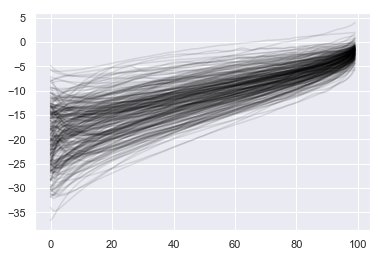

In [63]:
orig_data = sub_norm_data["data"]
for i in range(orig_data.shape[0]):
    plt.plot(orig_data[i, :], c="black", alpha=0.1)

In [64]:
new_datasets = config["new_datasets"]

In [65]:
new_datasets[0]["data_dir"] = "C:/Users/lindsayn/Documents/Github/drcme/drcme/bin/culture_vectors/"

In [66]:
new_data_objects = []
new_specimen_ids_list = []
for ds in new_datasets:
#     if len(ds["limit_to_cortical_layers"]) == 0:
    limit_to_cortical_layers = None
#     else:
#         limit_to_cortical_layers = ds["limit_to_cortical_layers"]

    data_for_spca, specimen_ids = ld.load_organized_data(project=ds["project"],
                                        base_dir=ds["data_dir"],
                                        use_noise=use_noise,
                                        dendrite_type=ds["dendrite_type"],
                                        need_structure=not ds["allow_missing_structure"],
                                        include_dend_type_null=ds["allow_missing_dendrite"],
                                        limit_to_cortical_layers=limit_to_cortical_layers,
                                        params_file=params_file)
    new_data_objects.append(data_for_spca)
    new_specimen_ids_list.append(specimen_ids)
data_for_spca = []
for i, do in enumerate(new_data_objects):
    for j, data_item in enumerate(do):
        if i == 0:
            data_for_spca.append({
                "data": data_item["data"].copy(),
                "part_keys": data_item["part_keys"],
            })
        else:
            data_for_spca[j]["data"] = np.vstack([data_for_spca[j]["data"],
                                                  data_item["data"]])
new_ids = np.hstack(new_specimen_ids_list)

In [67]:
culture_sub_norm_data = [d for d in data_for_spca if "isi_shape" in d["part_keys"]][0]

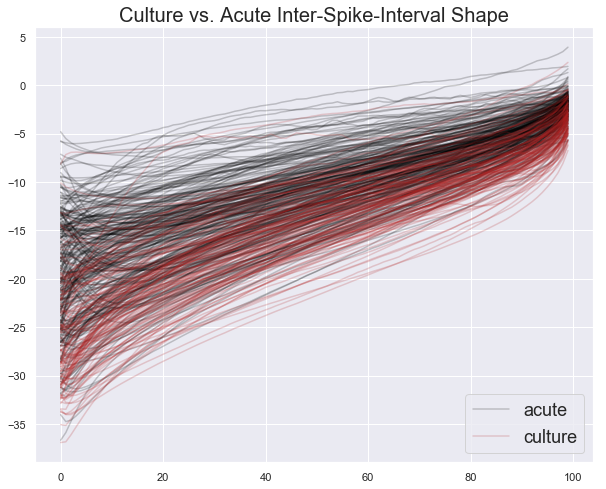

In [70]:
sns.set()
new_data = culture_sub_norm_data["data"]
plt.figure(figsize = (10,8))
my_label = "acute"
for i in range(orig_data.shape[0]):
    plt.plot(orig_data[i, :], c="black", alpha=0.2, label=my_label)
    my_label = "_nolegend_"

my_label = 'culture'
for i in range(new_data.shape[0]):
    plt.plot(new_data[i, :], c="firebrick", alpha=0.2, label= my_label)
    my_label = "_nolegend"

plt.legend(loc = 'lower right', fontsize= 18)
plt.title('Culture vs. Acute Inter-Spike-Interval Shape', fontsize = 20)
#plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/umap191023/isi.png")
#plt.xlim(110, 140)

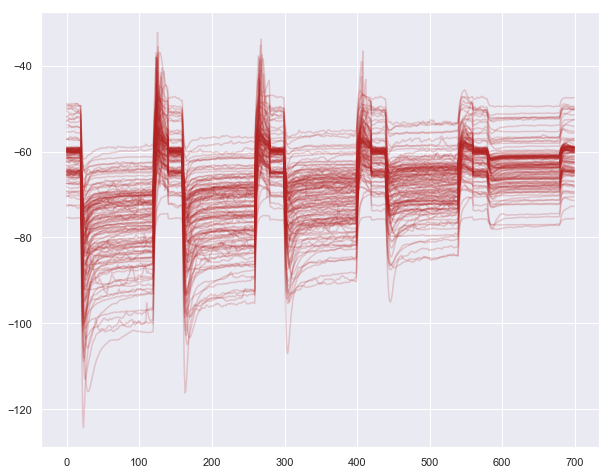

In [22]:
new_data = culture_sub_norm_data["data"]
plt.figure(figsize = (10,8))

my_label = 'culture'
for i in range(new_data.shape[0]):
    plt.plot(new_data[i, :], c="firebrick", alpha=0.2, label= my_label)
    my_label = "_nolegend"

In [ ]:
from sklearn.externals import joblib

In [ ]:
weights = joblib.load("\\\\allen\\programs\\celltypes\\workgroups\\ivscc\\nathang\\spca_output\\spca_loadings_human_inh_me_met.pkl")

In [ ]:
sn_wt = weights["subthresh_norm"]["loadings"].T

In [ ]:
new_data = culture_sub_norm_data["data"]
for i in range(orig_data.shape[0]):
    plt.plot(orig_data[i, :], c="black", alpha=0.1)

for i in range(new_data.shape[0]):
    plt.plot(new_data[i, :], c="firebrick", alpha=0.1)
    
plt.plot(sn_wt[2, :], c="green", linewidth=3)
plt.xlim(110, 140)

In [ ]:
culture_sub_norm_data = [d for d in data_for_spca if "subthresh_norm" in d["part_keys"]][0]

In [ ]:
new_data = culture_sub_norm_data["data"]
for i in range(orig_data.shape[0]):
    plt.plot(orig_data[i, :], c="black", alpha=0.1)

for i in range(new_data.shape[0]):
    plt.plot(new_data[i, :], c="firebrick", alpha=0.1)
    
#plt.xlim(110, 140)

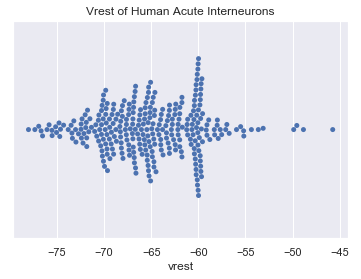

In [183]:
acute_dfi = acute_df[acute_df['class'] != 'Excitatory']
sns.swarmplot(x='vrest',data=acute_dfi, hue='class')
plt.title('Vrest of Human Acute Interneurons')
plt.savefig('C:/users/lindsayn/documents/github/analysis/figures/acute_vrest.png')

In [11]:
acute_df['class'].value_counts()

Excitatory    534
VIP           100
LAMP5         100
PVALB          78
SST            20
Name: class, dtype: int64

In [44]:
def get_specimen_info_from_lims_by_id(specimen_id):

    result = query("""
                  SELECT s.name, s.ephys_roi_result_id, s.id 
                  FROM specimens s 
                  WHERE s.id = %s
                  """ % specimen_id)[0]

    if result:
        return result["name"], result["ephys_roi_result_id"], result["id"]
    else:
        logging.info("Could not find specimen {:d}".format(specimen_id))
        return None, None, None


def get_nwb_path_from_lims(ephys_roi_result):

    # well known file type ID for NWB files is 475137571

    result = query("""
    SELECT f.filename, f.well_known_file_type_id, f.storage_directory FROM well_known_files f
    WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.well_known_file_type_id = 570280085
    """ % (ephys_roi_result,))[0]
    return result
    if result:
        nwb_path = result["storage_directory"] + 'output.nwb'#+ result["filename"]
        return nwb_path
    else:
        logging.info("Cannot find NWB file")
        return None

In [ ]:
# AND f.well_known_file_type_id = 475137571

In [9]:
def _connect(user=USER, host=HOST, database=DATABASE, password=PASSWORD, port=PORT):

    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()


def able_to_connect_to_lims():

    try:
        conn, cursor = _connect()
        cursor.close()
        conn.close()
        return True

    except Exception:
        return False


def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]


def query(query):
    conn, cursor = _connect()
    try:
        results = _select(cursor, query)
    finally:
        cursor.close()
        conn.close()
    return results


In [7]:

USER = "limsreader"
HOST = "limsdb2"
DATABASE = "lims2"
PASSWORD = "limsro"
PORT = 5432

In [46]:
get_specimen_info_from_lims_by_id(819177874)

(u'h19.03.002.12.01.01.01.06', 819177656, 819177874)

In [47]:
get_nwb_path_from_lims(819177656)

{'filename': u'h19.03.002.12.01.01.01.06.nwb',
 'storage_directory': u'/allen/programs/celltypes/production/humancelltypes/prod0/Ephys_Roi_Result_819177656/',
 'well_known_file_type_id': 570280085}